<div id="container" style="position:relative;">
<div style="float:left"><h1> Leveraging Data Science to Promote Transparency in Elections: </h1></div>
<div style="float:left"><h2> The case of Peru </h2></div> 
<div style="position:relative; float:right"><img style="height:60px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>    

### Notebook 4 of 4 : Application of Benford's Law  
**by Giancarlo Marchesi**

## Introduction

One of the limitations of the previous regression analysis is that it's performed on 97.7% of total observations. As we saw in the EDA notebook, 84452 of the 86488 polling stations have valid data for both rounds. 

However, the second round by itself has 86255 valid stations and, conversely, the first round has 85002. Information is lost when intersecting the two and because of inconsistencies in the number of elegible voters in between rounds. 

The application  of Benford's law can provide an additional consitency check for election results. In their paper *"What the Numbers Say: A Digit-Based Test for Election Fraud"* Bernd Beber and Alexandra Scacco in *Political Analysis (2012) 20:211–234* posit that "fair election procedures produce returns where last digits occur with equal frequency, but laboratory experiments indicate that individuals tend to favor some numerals over others, even when subjects have incentives to properly randomize". Since in the Peruvian election, ballot summary sheets are, ultimately, handwritten, any systematic bias from poll workers "inventing" the numbers could potentially show up under this lens. 

The authors tested for deviations in digit patterns using data from Sweden’s 2002 parliamentary elections, Senegal’s 2000 and 2007 presidential elections, and previously unavailable results from Nigeria’s 2003 presidential election. In line with observers’ expectations, they find substantial evidence that manipulation occurred in Nigeria as well as in Senegal in 2007, as the digit '0' was found to be overepresented in as statitistically significant manner, whereas elections in Sweeden show results for all 10 digits within the expected confidence interval. 

In this section, we apply Benford's law to the last digit of total votes and votes for Castillo and Fujimori for both rounds in each individual polling station. The results for each digit should be within the confidence interval to comply with Benford's law. 

### 1. Feature engineering 

It'll be necessary to extract the last digit of votes per polling statiton for each of the candidates and the total in the first and second round clean data sets that were exported during EDA. 

In [1]:
## Import the necessary libraries
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Importing the dataset with valid second round votes after EDA
dfsec=pd.read_csv('data/second_round_clean.csv')

In [3]:
dfsec.shape

(86255, 14)

In [4]:
## Importing the dataset with valid second round votes after EDA
dffir=pd.read_csv('data/first_round_clean.csv')

In [5]:
dffir.shape

(85002, 30)

#### 1.1 Second round data

In [6]:
dfsec.columns

Index(['Geocode', 'State', 'Province', 'District', 'Poll_station',
       'Ballot_summary_cond_2', 'Votes_2', 'Eligible_voters_2', 'Castillo_2',
       'Fujimori_2', 'Blank_2', 'Null_2', 'Contested_2', 'Region'],
      dtype='object')

In [7]:
## To perform Benford's law analysis we need the last digit of Castillo_2, Fujimori_2, Votes_2 
## First we turn them to strings
dfsec['str_Cast2']=dfsec['Castillo_2'].astype('str')
dfsec['str_Fuji2']=dfsec['Fujimori_2'].astype('str')
dfsec['str_Vote2']=dfsec['Votes_2'].astype('str')

In [8]:
dfsec.str_Cast2

0        115.0
1         71.0
2         71.0
3         66.0
4        125.0
         ...  
86250    101.0
86251     92.0
86252     98.0
86253     76.0
86254    105.0
Name: str_Cast2, Length: 86255, dtype: object

The digits have been converted from floats to objects. 

In [9]:
## To obtain the last digit of castillo votes
dfsec['last_Cast2']=dfsec['str_Cast2'].str[-3] 

In [10]:
dfsec['last_Cast2']

0        5
1        1
2        1
3        6
4        5
        ..
86250    1
86251    2
86252    8
86253    6
86254    5
Name: last_Cast2, Length: 86255, dtype: object

We've successfully extracted the last digit. Now it needs to be an integer. 

In [11]:
dfsec['last_Cast2']=dfsec['last_Cast2'].astype('int')

In [12]:
dfsec['last_Cast2']

0        5
1        1
2        1
3        6
4        5
        ..
86250    1
86251    2
86252    8
86253    6
86254    5
Name: last_Cast2, Length: 86255, dtype: int32

In [13]:
## Now to do the same with the other 2 necessary variables
dfsec['last_Fuji2']=dfsec['str_Fuji2'].str[-3]

In [14]:
dfsec['last_Fuji2']

0        7
1        8
2        0
3        5
4        7
        ..
86250    5
86251    4
86252    2
86253    2
86254    6
Name: last_Fuji2, Length: 86255, dtype: object

In [15]:
dfsec['last_Fuji2']=dfsec['last_Fuji2'].astype('int')

In [16]:
dfsec['last_Vote2']=dfsec['str_Vote2'].str[-3]
dfsec['last_Vote2']=dfsec['last_Vote2'].astype('int')

#### 1.2 First round data

In [17]:
dffir.columns

Index(['Geocode', 'State', 'Province', 'District', 'Poll_station',
       'Ballot_summary_cond_1', 'Votes_1', 'Eligible_voters_1', 'Humala',
       'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto', 'Urresti',
       'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez', 'Galvez',
       'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna', 'Blank_1', 'Null_1',
       'Contested_1', 'Region'],
      dtype='object')

In [18]:
##Turning the 3 variables to strings
dffir['str_Votes1']=dffir['Votes_1'].astype('str')
dffir['str_Fujimori1']=dffir['Fujimori_1'].astype('str')
dffir['str_Castillo1']=dffir['Castillo_1'].astype('str')

In [19]:
## Extracting the last digit and converting to integer
dffir['last_Vote1']=dffir['str_Votes1'].str[-3]
dffir['last_Vote1']=dffir['last_Vote1'].astype('int')

In [20]:
dffir['last_Vote1']

0        7
1        4
2        4
3        1
4        9
        ..
84997    8
84998    5
84999    3
85000    6
85001    7
Name: last_Vote1, Length: 85002, dtype: int32

In [21]:
## Extracting the last digit and converting to integer
dffir['last_Fuji1']=dffir['str_Fujimori1'].str[-3]
dffir['last_Fuji1']=dffir['last_Fuji1'].astype('int')

In [22]:
## Extracting the last digit and converting to integer
dffir['last_Cast1']=dffir['str_Castillo1'].str[-3]
dffir['last_Cast1']=dffir['last_Cast1'].astype('int')

### 2. Applying Benford's Law to total votes

#### 2.1 First round 

In [23]:
## Calculating the digit count for first round
dffir.groupby('last_Vote1')['last_Vote1'].count()

last_Vote1
0    8712
1    8367
2    8423
3    8473
4    8528
5    8593
6    8465
7    8571
8    8349
9    8521
Name: last_Vote1, dtype: int64

Let's calculate the confidence interval. 

In [24]:
## Creating a dataframe for better visualization 
tv1=pd.DataFrame(data=dffir.groupby('last_Vote1')['last_Vote1'].count())

In [25]:
##Renaming second column (both columns have the same name when coming out from the groupby)
tv1.rename(columns={'last_Vote1' : 'totdigit'}, inplace=True)

In [26]:
tv1['total']=85002

In [27]:
tv1['percent']=tv1['totdigit']/tv1['total']

In [28]:
tv1

,totdigit,total,percent
last_Vote1,,,
0,8712,85002,0.102492
1,8367,85002,0.098433
2,8423,85002,0.099092
3,8473,85002,0.099680
4,8528,85002,0.100327
5,8593,85002,0.101092
6,8465,85002,0.099586
7,8571,85002,0.100833
8,8349,85002,0.098221


In [29]:
## Calculating the mean
meantv1=tv1['percent'].mean()

In [30]:
meantv1

0.1

In [31]:
## calculating the standard deviation
std_tv1=tv1['percent'].std()

In [32]:
std_tv1

0.0012901096992837292

In [33]:
#Z score at the 99% level 
Z=2.5758

In [34]:
## Square root of 10
sqrt=np.sqrt(10)

In [35]:
### Calculating positive CI
citv1_pos=meantv1+(Z*std_tv1)/sqrt

In [36]:
citv1_pos

0.10105084528321846

In [37]:
### Calculating negative CI
citv1_neg=meantv1-(Z*std_tv1)/sqrt

In [38]:
citv1_neg

0.09894915471678155

In [39]:
x=[0,1,2,3,4,5,6,7,8,9]

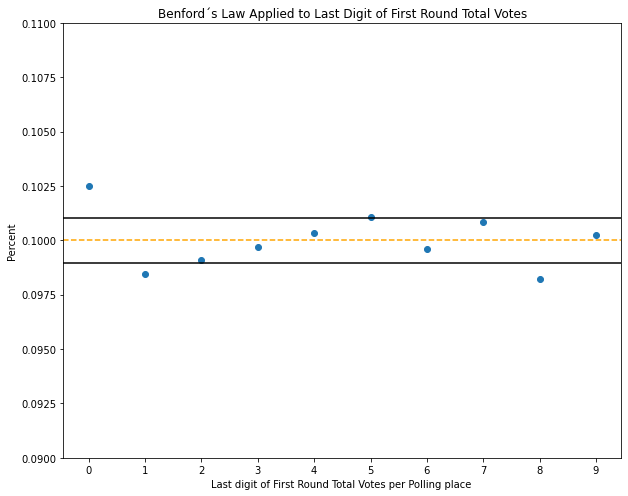

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(x, tv1['percent'])
plt.xlabel('Last digit of First Round Total Votes per Polling place ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of First Round Total Votes')
plt.axhline(meantv1, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(citv1_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(citv1_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

We see that 0 is slightly overrepresented, but the value is very close to 10%; 1 and 8 are slightly misrepresented, but on the whole the digits are very close to 10% each. 

#### 2.2 Second round

In [41]:
## Calculating the digit count for vote 2n round
dfsec.groupby('last_Vote2')['last_Vote2'].count()

last_Vote2
0    8737
1    8468
2    8785
3    8588
4    8605
5    8567
6    8658
7    8661
8    8712
9    8474
Name: last_Vote2, dtype: int64

Let's create a confidence intervals to plot along in the graph. Since we know the population standard deviation we will use a Z score. It's a population because it's the universal set of all valid votes for the second round election. 

In [42]:
## Creating a dataframe for better visualization 
tv2=pd.DataFrame(data=dfsec.groupby('last_Vote2')['last_Vote2'].count())

In [43]:
##Renaming second column (both columns have the same name when coming out from the groupby)
tv2.rename(columns={'last_Vote2' : 'totdigit'}, inplace=True)

In [44]:
tv2['total']=86255

In [45]:
tv2['percent']=tv2['totdigit']/tv2['total']

In [46]:
tv2

,totdigit,total,percent
last_Vote2,,,
0,8737,86255,0.101293
1,8468,86255,0.098174
2,8785,86255,0.101849
3,8588,86255,0.099565
4,8605,86255,0.099762
5,8567,86255,0.099322
6,8658,86255,0.100377
7,8661,86255,0.100412
8,8712,86255,0.101003


In [47]:
## Calculating the mean
meantv2=tv2['percent'].mean()

In [48]:
## calculating the standard deviation
std_tv2=tv2['percent'].std()

In [49]:
### Calculating positive CI
citv2_pos=meantv2+(Z*std_tv2)/sqrt

In [50]:
citv2_pos

0.10099879181073931

In [51]:
### Calculating negative CI
citv2_neg=meantv2-(Z*std_tv2)/sqrt

In [52]:
citv2_neg

0.09900120818926067

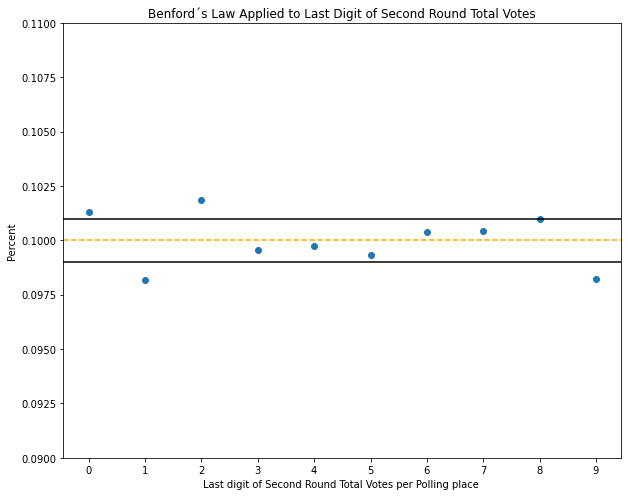

In [53]:
plt.figure(figsize=(10,8))
plt.scatter(x, tv2['percent'])
plt.xlabel('Last digit of Second Round Total Votes per Polling place ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of Second Round Total Votes')
plt.axhline(meantv2, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(citv2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(citv2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

Digits 1 and 9 are slightly underreprestented, whereas 0 and 2 is slightly overrepresented. However, in all cases they are very close to 10. There does not seem to be an anomaly with regarding to digits being over repeated do to manual input at a large scale.  

### 3. Applying Benford's law to Fujimori vote

#### 3.1 First round

In [54]:
## Calculating the digit count for vote 1st round
dffir.groupby('last_Fuji1')['last_Fuji1'].count()

last_Fuji1
0    8726
1    8436
2    8858
3    8905
4    8774
5    8855
6    8421
7    8207
8    8101
9    7719
Name: last_Fuji1, dtype: int64

In [55]:
## Creating a dataframe for better visualization 
fuji1=pd.DataFrame(data=dffir.groupby('last_Fuji1')['last_Fuji1'].count())

In [56]:
##Renaming second column (both columns have the same name when coming out from the groupby)
fuji1.rename(columns={'last_Fuji1' : 'totdigit'}, inplace=True)

In [57]:
fuji1['total']=85002

In [58]:
fuji1['percent']=fuji1['totdigit']/fuji1['total']

In [59]:
fuji1

,totdigit,total,percent
last_Fuji1,,,
0,8726,85002,0.102656
1,8436,85002,0.099245
2,8858,85002,0.104209
3,8905,85002,0.104762
4,8774,85002,0.103221
5,8855,85002,0.104174
6,8421,85002,0.099068
7,8207,85002,0.096551
8,8101,85002,0.095304


We know that the mean is 0.1. 

In [60]:
## calculating the standard deviation
std_f1=fuji1['percent'].std()

In [61]:
### Calculating positive CI
cif1_pos=0.1+(Z*std_f1)/sqrt

In [62]:
cif1_pos

0.10379251392996562

In [63]:
### Calculating negative CI
cif1_neg=0.1-(Z*std_f1)/sqrt

In [64]:
cif1_neg

0.09620748607003439

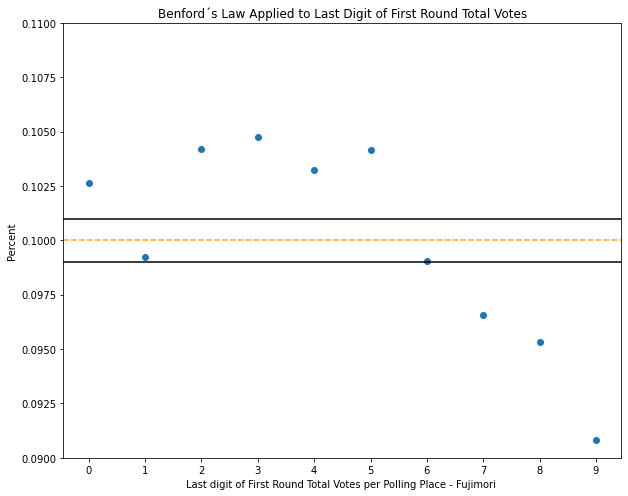

In [65]:
plt.figure(figsize=(10,8))
plt.scatter(x, fuji1['percent'])
plt.xlabel('Last digit of First Round Total Votes per Polling Place - Fujimori ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of First Round Total Votes')
plt.axhline(meantv2, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(citv2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(citv2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

In this case, we are seeing quite a bit of variability; 8 and 9 are underrepresented, while 0, 2, 3, 4 and 5 are overrespresented. Let's remember that Fujimori only got 11% of total votes in the first round.

#### 3.2 Second round

In [66]:
## Calculating the digit count for vote 2n round
dfsec.groupby('last_Fuji2')['last_Fuji2'].count()

last_Fuji2
0    8622
1    8519
2    8742
3    8601
4    8660
5    8787
6    8571
7    8591
8    8612
9    8550
Name: last_Fuji2, dtype: int64

In [67]:
## Creating a dataframe for better visualization 
fuji2=pd.DataFrame(data=dfsec.groupby('last_Fuji2')['last_Fuji2'].count())

In [68]:
##Renaming second column (both columns have the same name when coming out from the groupby)
fuji2.rename(columns={'last_Fuji2' : 'totdigit'}, inplace=True)

In [69]:
fuji2['total']=86255

In [70]:
fuji2['percent']=fuji2['totdigit']/fuji2['total']

In [71]:
fuji2

,totdigit,total,percent
last_Fuji2,,,
0,8622,86255,0.099959
1,8519,86255,0.098765
2,8742,86255,0.101351
3,8601,86255,0.099716
4,8660,86255,0.100400
5,8787,86255,0.101872
6,8571,86255,0.099368
7,8591,86255,0.099600
8,8612,86255,0.099843


In [72]:
## calculating the standard deviation
std_fuji2=fuji2['percent'].std()

In [73]:
### Calculating positive CI
cif2_pos=0.1+(Z*std_fuji2)/sqrt

In [74]:
### Calculating positive CI
cif2_neg=0.1-(Z*std_fuji2)/sqrt

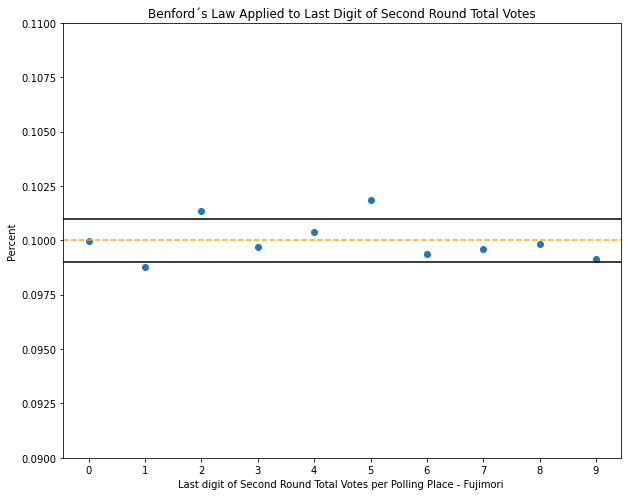

In [75]:
plt.figure(figsize=(10,8))
plt.scatter(x, fuji2['percent'])
plt.xlabel('Last digit of Second Round Total Votes per Polling Place - Fujimori ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of Second Round Total Votes')
plt.axhline(meantv2, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(citv2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(citv2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

All digits are very close or inside the confidence interval; 5 is slightly overrepresented and 1 is slightly underpresented. 

### 4. Applying Benford's law to Castillo vote

#### 4.1 First round

In [76]:
## Calculating the digit count for vote 1st round
dffir.groupby('last_Cast1')['last_Cast1'].count()

last_Cast1
0    9131
1    8934
2    8876
3    8947
4    8627
5    8645
6    8436
7    8054
8    7790
9    7562
Name: last_Cast1, dtype: int64

In [77]:
## Creating a dataframe for better visualization 
cast1=pd.DataFrame(data=dffir.groupby('last_Cast1')['last_Cast1'].count())

In [78]:
##Renaming second column (both columns have the same name when coming out from the groupby)
cast1.rename(columns={'last_Cast1' : 'totdigit'}, inplace=True)

In [79]:
cast1['total']=85002

In [80]:
cast1['percent']=cast1['totdigit']/cast1['total']

In [81]:
cast1

,totdigit,total,percent
last_Cast1,,,
0,9131,85002,0.107421
1,8934,85002,0.105103
2,8876,85002,0.104421
3,8947,85002,0.105256
4,8627,85002,0.101492
5,8645,85002,0.101703
6,8436,85002,0.099245
7,8054,85002,0.094751
8,7790,85002,0.091645


In [82]:
## calculating the standard deviation
std_c1=cast1['percent'].std()

In [83]:
### Calculating positive CI
cic1_pos=0.1+(Z*std_c1)/sqrt

In [84]:
### Calculating positive CI
cic1_neg=0.1-(Z*std_c1)/sqrt

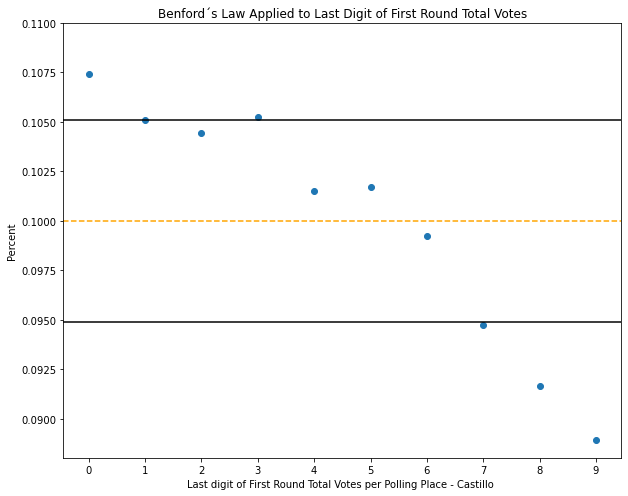

In [85]:
plt.figure(figsize=(10,8))
plt.scatter(x, cast1['percent'])
plt.xlabel('Last digit of First Round Total Votes per Polling Place - Castillo ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of First Round Total Votes')
plt.axhline(0.1, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(cic1_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(cic1_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

Like in the case of Fujimori in the first round, we see more variability in the digits; 0 is overrepresented where 8 and 9 are underrepresented. 

#### 4.2 Second round

In [86]:
## Calculating the digit count for vote 2n round
dfsec.groupby('last_Cast2')['last_Cast2'].count()

last_Cast2
0    8787
1    8662
2    8639
3    8558
4    8587
5    8836
6    8535
7    8536
8    8589
9    8526
Name: last_Cast2, dtype: int64

In [87]:
## Creating a dataframe for better visualization 
cast2=pd.DataFrame(data=dfsec.groupby('last_Cast2')['last_Cast2'].count())

In [88]:
##Renaming second column (both columns have the same name when coming out from the groupby)
cast2.rename(columns={'last_Cast2' : 'totdigit'}, inplace=True)

In [89]:
cast2['total']=86255

In [90]:
cast2['percent']=cast2['totdigit']/cast2['total']

In [91]:
cast2

,totdigit,total,percent
last_Cast2,,,
0,8787,86255,0.101872
1,8662,86255,0.100423
2,8639,86255,0.100157
3,8558,86255,0.099217
4,8587,86255,0.099554
5,8836,86255,0.102440
6,8535,86255,0.098951
7,8536,86255,0.098962
8,8589,86255,0.099577


In [92]:
## calculating the standard deviation
std_c2=cast2['percent'].std()

In [93]:
### Calculating positive CI
cic2_pos=0.1+(Z*std_c2)/sqrt

In [94]:
### Calculating positive CI
cic2_neg=0.1-(Z*std_c2)/sqrt

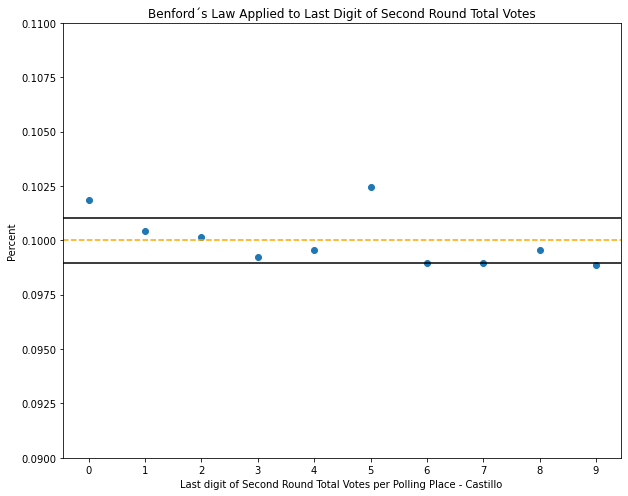

In [95]:
plt.figure(figsize=(10,8))
plt.scatter(x, cast2['percent'])
plt.xlabel('Last digit of Second Round Total Votes per Polling Place - Castillo ')
plt.ylabel('Percent')
plt.title('Benford´s Law Applied to Last Digit of Second Round Total Votes')
plt.axhline(0.1, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(cic2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(cic2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))
plt.show()

Digits 1 and 5 are slightly over represented, but mostly hover around 10 percent. 

### 5. Conclusion 

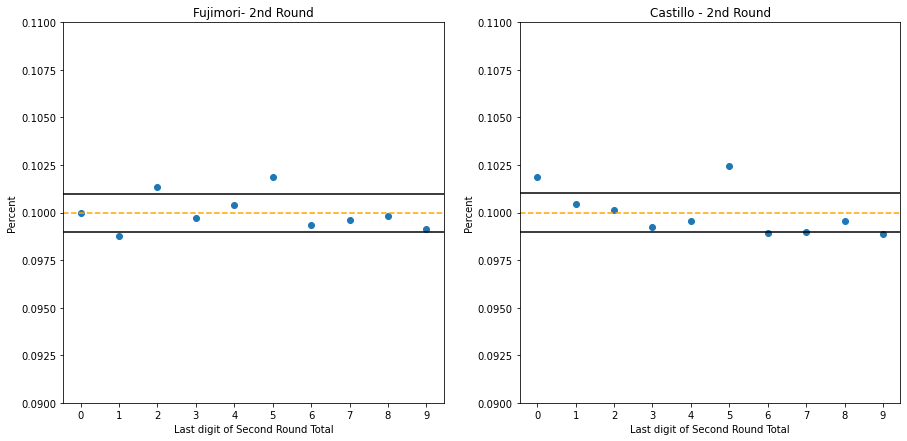

In [96]:
## Putting them side by side
plt.subplots(1,2, figsize=(15,7))

plt.subplot(1, 2, 1)
plt.scatter(x, fuji2['percent'])
plt.xlabel('Last digit of Second Round Total')
plt.ylabel('Percent')
plt.title('Fujimori- 2nd Round')
plt.axhline(meantv2, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(citv2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(citv2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))

plt.subplot(1, 2, 2)
plt.scatter(x, cast2['percent'])
plt.xlabel('Last digit of Second Round Total')
plt.ylabel('Percent')
plt.title('Castillo - 2nd Round')
plt.axhline(0.1, 0,1, color="orange", linestyle="--", label='mean')
plt.axhline(cic2_pos, 0,1, color="black", linestyle="-", label='ci_pos')
plt.axhline(cic2_neg, 0,1, color="black", linestyle="-", label='ci_neg')
plt.yticks(np.arange(0.09, 0.11, step=0.0025))
plt.xticks(np.arange(0, 10, step=1))

plt.show()

- The distribution of digits in the second round is very similar in the case of both candidates. The five is slightly overrepresented in both cases. None of the graphs analyzed in this section are similar to the findings of Beber and Scacco(2012) in Nigeria, where the '0' digit for total votes was higher than 15%. Hence, there is no evidence to suspect foul play for or against either one of the candidates. 

- Both candidates show a more variable distribution in the first round with 8 and 9 being slightly underrepresented, yet the total votes distribution seems normal.  

---